### Library loading

In [1]:
%run nbloader.py
import matplotlib
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pyplot as plt
import root_numpy
import pandas as pd
import numpy as np
from sklearn.svm import SVC

from multiprocessing import Pool
BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205
LAYER_DIFF = 1293

### Functions

#### Data load

In [2]:
def load_mc(filename="data/mcdata2.root", step=1):
    mc = root_numpy.root2array(
                        filename,
                        treename="Data",
                        branches=["Event_id", "ele_P",
                                   "BT_X", "BT_Y", "BT_Z",
                                   "BT_SX", "BT_SY", "BT_plate",
                                   "ele_x", "ele_y", "ele_z", 
                                   "ele_sx", "ele_sy", 
                                   "chisquare", "alfa", "deltaSx", "deltaSy"],
                        step=step)
    pmc = pd.DataFrame(mc)
    pmc['numtracks'] = pmc.BT_X.apply(lambda x: len(x))
    # cuts
    shapechange = [pmc.shape[0]]
    pmc = pmc[pmc.ele_P > 0.1]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_x.abs() < BRICK_X / 2 - SAFE_M]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_y.abs() < BRICK_Y / 2 - SAFE_M]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_z < 0]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.numtracks > 3]
    shapechange.append(pmc.shape[0])
    print ("numtracks reduction by cuts: ", shapechange)
    pmc.BT_X += BRICK_X / 2
    pmc.BT_Y += BRICK_Y / 2
    pmc.BT_Z += BRICK_Z / 2
    pmc.ele_x += BRICK_X / 2
    pmc.ele_y += BRICK_Y / 2
    pmc.ele_z += BRICK_Z / 2

    pmc.BT_Z = (pmc.BT_plate - 1) * 1293
    
    return pmc
    

In [3]:
def load_bg(step=10000):
    # ignore 57th layer since it looks different
    etalon_plates = []
    for p in range(48, 57):
        backtracks = root_numpy.root2array("data/129294.{p}.1.1000.cp.root".format(p=p), 
                                       treename="couples", 
                                       branches=["s.eX", "s.eY", "s.eZ",
                                                "s.eTX", "s.eTY",
                                                "s.eChi2"], step=step)
        etalon_plates.append(backtracks)
        
    df = None
    for p in range(58):
        plate = np.copy(etalon_plates[p % len(etalon_plates)])
        plate['s.eZ'] = p * 1293
        if df is None:
            df = pd.DataFrame(plate)
        else:
            df = pd.concat([df, pd.DataFrame(plate)], ignore_index=True)
    df['plate_index'] = df['s.eZ'].astype('category').cat.codes + 1
    print ("bg: {n} tracks".format(n=df.shape[0]))
    return df

In [4]:
import numpy as np
import pandas as pd

BT_Z_unique = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])
BRICK_X_MIN = 27762
BRICK_X_MAX = 72240
BRICK_Y_MIN = 3312
BRICK_Y_MAX = 76710
SAFE_M = 5000
dZ = 205

def shift_mc_data_with_margin(pmc, pbg, x_safe_margin = 0, y_safe_margin = 0):
    pmc_new = pmc.copy()
    mc_range = (pmc['ele_x'].max() - pmc['ele_x'].min(), pmc['ele_y'].max() - pmc['ele_y'].min())
    def coordinate_mover(x, min_mc_coord, amplitude, margin):
        return ((x - min_mc_coord) / amplitude - 0.5) * 2* (- margin - (left_bound - right_bound) / 2) +\
                (left_bound + right_bound) / 2
    
    right_bound = pbg['s.eX'].max()
    left_bound = pbg['s.eX'].min()
    
    pmc_new.ele_x = coordinate_mover(pmc.ele_x, pmc['ele_x'].min(), mc_range[0], x_safe_margin)
    pmc_new.BT_X = pmc['BT_X'] - (pmc['ele_x'] - pmc_new.ele_x)
    
    right_bound = pbg['s.eY'].max()
    left_bound = pbg['s.eY'].min()    
    
    pmc_new.ele_y = coordinate_mover(pmc.ele_y, pmc['ele_y'].min(), mc_range[1], y_safe_margin)
    pmc_new.BT_Y = pmc['BT_Y'] - (pmc['ele_y'] - pmc_new.ele_y)
    return pmc_new

def combine_mc_bg(pmc, pbg, events = [0], bg_frac=0.1):
    '''Create mixed DataFrame from selected MC Even_Id's and
       fraction of background'''
    #first of all generate background with random permutation by Z-axis
    
    pbg_frac = pbg.sample(frac=bg_frac)
    pbg_frac['s.eZ'] = np.random.choice(BT_Z_unique, size=len(pbg_frac))
    dmix = pd.DataFrame([
                pbg_frac['s.eX'],
                pbg_frac['s.eY'],
                pbg_frac['s.eZ'],
                pbg_frac['s.eTX'],
                pbg_frac['s.eTY'],
                pbg_frac['s.eChi2']],
                index=['X', 'Y', 'Z', 'TX', 'TY', 'chi2']).T
    dmix['plate_number'] = pbg_frac['s.eZ'].apply(lambda x:
                                                  np.where(BT_Z_unique == x)[0][0] + 1)
    dmix['signal'] = False
    dmix['event_id'] = -999
    
    dd = dmix
    print("Number of BG basetracks:", dmix.shape[0])
    #now we are generating signal by shifting electron position
    
    pmc_new = shift_mc_data_with_margin(pmc, pbg, 5000, 5000)
    pmc_new['chisquare'] = pmc_new.chisquare.apply(lambda x: x[x < 3]) 
    df = pmc_new[pmc_new.Event_id.isin(events)]
    print("Number of MC events:", df.shape[0])
    
    for _, row in df.iterrows():
        dmc = pd.DataFrame([        
                    row['BT_X'],
                    row['BT_Y'],
                    row['BT_Z'],
                    row['BT_SX'],
                    row['BT_SY'],
                    row['chisquare']],
                    index=['X', 'Y', 'Z', 'TX', 'TY', 'chi2']).T
        dmc['plate_number'] = row['BT_plate']
        dmc['signal'] = True
        dmc['event_id'] = row['Event_id']
        
        dd = pd.concat([dd, dmc], ignore_index=True)

    return dd

### Utils

In [5]:
def compute_track_continuation(track):
    return track[0] + LAYER_DIFF * track[3], track[1] + LAYER_DIFF * track[4]

#### Plot functions

In [6]:
def plot_bg_and_mc(pbg, pmc, id=0, step=1):
    df = pbg
    # mind the order!
    d0 = pd.DataFrame([
                df['Z'][::step],
                df['X'][::step],
                df['Y'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['TX'][::step]*dZ,
            df['TY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)

    df = pmc

    # mind the order!
    d0 = pd.DataFrame([
                df['Z'],
                df['X'],
                df['Y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['TX']*dZ,
            df['TY']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    print(d1.shape)
    #print (d0)§
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-0, elev=0)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

In [7]:
def plot_pairs(d0, d1, df):
    dZ = 205

    # mind the order!
    d00 = pd.DataFrame([
                df['Z'][:],
                df['X'][:],
                df['Y'][:]],
                index=['z', 'x', 'y']).T
    numtracks = d00.shape[0]
    dd = pd.DataFrame([
            df['TX'][:]*dZ,
            df['TY'][:]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d11 = d00 + dd

    C = plt.cm.Blues(0.5)
    lc = Line3DCollection(zip(d00.values, d11.values), colors=C, alpha=0.5, lw=2)
    numtracks = len(d0[:, 0])
    

    C = plt.cm.Reds(0.5)
    lb = Line3DCollection(zip(d0[:, [2, 0, 1]], d1[:, [2, 0, 1]]), colors=C, alpha=0.9, lw=2)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-103, elev=16)
    ax.add_collection3d(lc)
    ax.add_collection3d(lb)

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_xlim(d0[:, 2].min(), d0[:, 2].max())
    ax.set_ylim(d0[:, 0].min(), d0[:, 0].max())
    ax.set_zlim(d0[:, 1].min(), d0[:, 1].max())

#### Training samples generators

In [8]:
def generate_training_sample_signal(data, ip_threshold = 0.4):
    event_id = set(data.event_id)
    event_id.remove(-999)
    
    parents = list()
    sons = list()
    
    for id in event_id:        
        shower = data[data.event_id == id].values
        z_coordinates = list(set(shower[:, 2]))
        z_coordinates.sort()

        for i in range(len(z_coordinates) - 1):
            for track in shower[shower[:, 2] == z_coordinates[i] ,:]:
                next_layer = shower[shower[:, 2] == z_coordinates[i + 1] ,:]
                if len(next_layer) != 0:
                    IP = compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float))[:, 2]
                    if (IP.min() < ip_threshold):
                        parents.append(track)
                        sons.append(next_layer[IP.argmin(), :])

    sons = np.asarray(sons)
    parents = np.asarray(parents)
    
    signal_part = compute_features(sons[:, :6].astype(float), parents[:, :6].astype(float))
    signal_part = np.insert(signal_part, len(signal_part[0, :]), 1, axis = 1)
    
    return signal_part

def generate_training_sample_noise(data, box = 10000, iterations = 40):
    background = data[data.event_id == -999].values
    noise_sons = list()
    noise_parents = list()
    
    for i in range(iterations):
        number = np.random.randint(len(background))
        track = background[number]
        
        next_layer = background[background[:, 2] == track[2] + 1293]
        track_cont = compute_track_continuation(track)
        
        bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box) & (abs(next_layer[:, 1] - track_cont[1]) < box)
        next_layer = next_layer[bool_index]
        if len(next_layer) != 0:
            noise_sons.extend([track] * len(next_layer))
            noise_parents.append(next_layer)

    noise_sons = np.asarray(noise_sons)
    noise_parents = np.concatenate(noise_parents)
    
    noise_part = compute_features(noise_sons[:, :6].astype(float), noise_parents[:, :6].astype(float))
    noise_part = np.insert(noise_part, len(noise_part[0, :]), 0, axis = 1)
    
    return noise_part

### SVM processing algorithm

In [9]:
def find_similar(track, next_layer, classifier, threshold, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    track_cont = compute_track_continuation(track)
    bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box_size) & (abs(next_layer[:, 1] - track_cont[1]) < box_size)
    
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    if len(next_layer) == 0:
        return np.array([])
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float)))[:, 1]
    result = dist > threshold
    
    return indexes[result]

def clear_layer(to_clear, to_compare, classifier, threshold, box_size):
    if (len(to_clear) == 0):
        return to_clear
    final_result = np.ndarray((len(to_clear,)),dtype=np.object)
    for i in xrange(len(to_clear)):
        result = find_similar(to_clear[i], to_compare, classifier, threshold, box_size)
        final_result[i] = result
                            
    f = np.vectorize(len)
    index = f(final_result) > 0
    
    to_clear = to_clear[index, :]
    if len(to_clear) == 0:
        return to_clear
    result = np.unique(np.hstack(final_result[index]))
    
    to_compare = to_compare[result]
    return np.concatenate([to_clear, to_compare])

def shower_finder(data, classifier, number_of_iterations = 1, threshold = 0.98, box_size = 3000, start_plate = 0):
    layers = list(set(data[:, 2]))
    layers.sort()
    for i in range(start_plate ,len(layers) - 1):
        cleared_data = clear_layer(data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, threshold, box_size)
        data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
        data = np.concatenate([data, cleared_data])    
    return data

#### Metrics (Fix it) (Add computation of the curve inside the cone and so on)

In [10]:
def precision_recall(cleared_data, original_shower_size):
    tp = np.sum(cleared_data.signal == 1) + 0.
    fp = np.sum(cleared_data.signal == 0)
    precision = tp / (tp + fp)
    recall = tp / original_shower_size
    return [precision, recall]

#### Feature computation

In [11]:
def compute_features(sons, parents):
    
    distance = np.sqrt(np.sum((parents[:, 0:3] - sons[:, 0:3])**2, axis = 1))
    tan_angle = np.tan(np.arccos(1/(np.sqrt(np.sum((sons - parents)[:, 3:5]**2, axis = 1) + 1))))
    
    track_begin = sons[:, 0:3]

    track_end = np.copy(track_begin)
    track_end[:, 0] += dZ * sons[:, 3]
    track_end[:, 1] += dZ * sons[:, 4]
    track_end[:, 2] += dZ
    track_diff = track_end - track_begin
    angle_z_son = (dZ ** 2)/(np.linalg.norm(track_diff, axis = 1) * dZ)
    
    
    track_diff_par = np.transpose(np.asarray([dZ * parents[:, 3], dZ * parents[:, 4]]))
    track_diff_par = np.insert(track_diff_par, 2, dZ, axis = 1)
    
    
    IP_1 = np.linalg.norm(np.cross(parents[:, 0:3] - track_end, parents[:, 0:3] - track_begin), axis = 1)/np.linalg.norm(track_diff, axis = 1)
    IP_2 = np.linalg.norm(np.cross(track_end - parents[:, 0:3], track_end - parents[:, 0:3] - track_diff_par), axis = 1)/np.linalg.norm(track_diff_par, axis = 1)

    angle_z_parents = (dZ ** 2)/(np.linalg.norm(track_diff_par, axis = 1) * dZ)
    return np.transpose(np.asarray([distance/dZ, tan_angle, IP_1/dZ, IP_2/dZ ,angle_z_son, angle_z_parents, sons[:,5], parents[:,5]]))

### Data preprocessing

In [12]:
pbg = load_bg(step=1)

bg: 27322110 tracks


In [13]:
pmc = load_mc(step=1)

('numtracks reduction by cuts: ', [18724, 18678, 17031, 15258, 7845, 7510])


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
np.random.seed(42)
pbg_train, pbg_test = train_test_split(pbg, test_size = 0.5)
pmc_train, pmc_test = train_test_split(pmc, test_size = 0.5)

In [16]:
ind = pmc_train.sample(frac=0.03).Event_id.values

In [17]:
tested_data = combine_mc_bg(pmc_train, pbg_train, ind, bg_frac = 0.0005)

('Number of BG basetracks:', 6831)
('Number of MC events:', 113)


### Check the value of IP inside 'generate_training_sample_signal' function

In [18]:
event_id = set(tested_data.event_id)
event_id.remove(-999)
    
parents = list()
sons = list()
           
shower = tested_data[tested_data.event_id == list(event_id)[0]].values

z_coordinates = list(set(shower[:, 2]))
z_coordinates.sort()

for i in range(len(z_coordinates) - 1):
    for track in shower[shower[:, 2] == z_coordinates[i] ,:]:
        next_layer = shower[shower[:, 2] == z_coordinates[i + 1] ,:]
        if len(next_layer) != 0:
            IP = compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float))[:, 2]
            if (IP.min() < 0.4):
                parents.append(track)
                sons.append(next_layer[IP.argmin(), :])

sons = np.asarray(sons)
parents = np.asarray(parents)

In [19]:
plot_pairs(sons, parents, tested_data[tested_data.event_id == list(event_id)[0]])

### Train SVM

In [20]:
ind = pmc_train.sample(frac=0.1).Event_id.values

In [21]:
train_data = combine_mc_bg(pmc_train, pbg_train, ind, bg_frac = 0.1)

('Number of BG basetracks:', 1366106)
('Number of MC events:', 376)


In [22]:
np.random.seed(42)
signal_train_sample = generate_training_sample_signal(train_data, ip_threshold=0.4)

In [23]:
np.random.seed(42)
noise_train_sample = generate_training_sample_noise(train_data)

In [24]:
print 'Signal part size: ' + str(len(signal_train_sample))
print 'Noise part size: ' + str(len(noise_train_sample))

Signal part size: 141071
Noise part size: 105906


In [25]:
df = np.random.permutation(np.concatenate([noise_train_sample, signal_train_sample]))

In [26]:
svm = SVC(C = 10, probability = True)
svm.fit(df[:50000, :8], df[:50000, 8])

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### TO DO: SVM cross - validation

### Check SVM step starting from a certain plate

In [27]:
ind = pmc_train.sample(frac=0.05).Event_id.values
cv_data = combine_mc_bg(pmc_train, pbg_train, ind, bg_frac = 0.01)

('Number of BG basetracks:', 136611)
('Number of MC events:', 188)


In [28]:
cleared_data = pd.DataFrame(shower_finder(cv_data.values, svm, threshold = 0.95, start_plate=1), columns=cv_data.columns)

In [29]:
plot_bg_and_mc(cleared_data[cleared_data.signal == False], cleared_data[cleared_data.signal == True])

(1870, 3)


### Try modification of SVM step without deleting tracks on the next plate

#### At first, we need to rewrite some functions.

## Sequential approach

In [31]:
def svm_iterative_processing(data, classifier, threshold = 0.98, number_iterations = 1, box_size = 3000):
    every_iteration_data = []
    for _ in range(number_iterations):
        data = shower_finder_iterative(data, classifier, threshold = threshold, box_size=box_size)
        every_iteration_data.append(np.copy(data))
    return every_iteration_data

def find_similar_iterative(track, next_layer, classifier, threshold, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    track_cont = compute_track_continuation(track)
    bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box_size) & (abs(next_layer[:, 1] - track_cont[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    if len(next_layer) == 0:
        return -1
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float)))[:, 1]
    son = np.argmax(dist)
    if dist[son] > threshold:
        return indexes[son]
    else:
        return -1

def clear_layer_iterative(to_clear, to_compare, classifier, threshold, box_size):
    if (len(to_clear) == 0):
        return to_clear
    tracks_to_leave = np.apply_along_axis(arr=to_clear, axis=1, func1d=find_similar_iterative, next_layer = to_compare, classifier = classifier, threshold =  threshold, box_size = box_size)
    bool_leave = tracks_to_leave >= 0
    to_compare[tracks_to_leave[bool_leave], -1] = to_clear[bool_leave, -1] + 1
    
    return np.concatenate([to_clear[np.logical_or(bool_leave, to_clear[:, -1] > 3)], to_compare])

def shower_finder_iterative(data, classifier, number_of_iterations = 1, threshold = 0.98, box_size = 3000, start_plate = 0):
    mod_data = np.ones((data.shape[0],data.shape[1] + 1))
    mod_data[:,:-1] = data
    data = mod_data
    
    layers = list(set(data[:, 2]))
    layers.sort()
    for i in range(start_plate ,len(layers) - 1):
        cleared_data = clear_layer_iterative(data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, threshold, box_size)
        data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
        data = np.concatenate([data, cleared_data])
    return data[data[:, 2] != layers[-1]][:, :-1]

## Parallel approach

In [35]:
def shower_finder_iterative_paralel(data, classifier, pool, number_of_iterations = 1, threshold = 0.98, box_size = 3000, start_plate = 0):
    
    layers = list(set(data[:, 2]))
    layers.sort()
    
    data_list = []
    
    for i in range(start_plate ,len(layers) - 1):
        data_list.append((data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, threshold, box_size))

    result = pool.map(clear_layer_iterative_paralel, data_list)
    return np.concatenate(result)

def clear_layer_iterative_paralel(args):
    to_clear, to_compare, classifier, threshold, box_size = args
    if (len(to_clear) == 0):
        return to_clear
    tracks_to_leave = np.apply_along_axis(arr=to_clear, axis=1, func1d=find_similar_iterative, next_layer = to_compare, classifier = classifier, threshold =  threshold, box_size = box_size)
    bool_leave = tracks_to_leave >= 0
    
    return to_clear[bool_leave]

def svm_iterative_processing_paralel(data, classifier, threshold = 0.98, number_iterations = 1, box_size = 3000):
    pool = Pool(processes=16)
    every_iteration_data = []
    for _ in range(number_iterations):
        data = shower_finder_iterative_paralel(data, classifier, pool, threshold = threshold, box_size=box_size)
        every_iteration_data.append(np.copy(data))
        
    pool.close()
    pool.join()
    
    return every_iteration_data

## Probabolistic approach

In [66]:
def svm_iterative_processing_proba(data, classifier, number_iterations = 1, box_size = 3000):
    every_iteration_data = []
    for _ in range(number_iterations):
        data = shower_finder_iterative_proba(data, classifier, box_size=box_size)
        every_iteration_data.append(np.copy(data))
    return every_iteration_data

def find_similar_iterative_proba(track, next_layer, classifier, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    track_cont = compute_track_continuation(track)
    bool_index = (abs(next_layer[:, 0] - track_cont[0]) < box_size) & (abs(next_layer[:, 1] - track_cont[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    if len(next_layer) == 0:
        return np.array([-1., 0.])
    dist = classifier.predict_proba(compute_features(np.repeat(np.array([track]), len(next_layer), 0)[:, :6].astype(float), next_layer[:, :6].astype(float)))[:, 1]
    son = np.argmax(dist)

    return np.array([indexes[son], dist[son]])

def clear_layer_iterative_proba(to_clear, to_compare, classifier, box_size):
    if (len(to_clear) == 0):
        return to_clear
    
    result = np.apply_along_axis(arr=to_clear, axis=1, func1d=find_similar_iterative_proba, next_layer = to_compare, classifier = classifier, box_size = box_size)
    indexes, proba = result[:, 0], result[:, 1]
    
    positive_index = indexes >= 0
    zero_proba = to_clear[:, -1] == 0
    
    to_clear[np.logical_and(positive_index, zero_proba), -1] = 1 - proba[np.logical_and(positive_index, zero_proba)]
    to_clear[np.logical_and(positive_index, np.logical_not(zero_proba)), -1] *= 1 - proba[np.logical_and(positive_index, np.logical_not(zero_proba))]
    
    
    to_compare[np.array(indexes[positive_index], dtype = int), -1] = to_clear[positive_index, -1] * (1 - proba[positive_index])
    
    return np.concatenate([to_clear, to_compare])

def shower_finder_iterative_proba(data, classifier, number_of_iterations = 1, box_size = 3000, start_plate = 0):
    mod_data = np.zeros((data.shape[0],data.shape[1] + 1))
    mod_data[:,:-1] = data
    data = mod_data
    
    layers = list(set(data[:, 2]))
    layers.sort()
    for i in range(start_plate ,len(layers) - 1):
        cleared_data = clear_layer_iterative_proba(data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, box_size)
        data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
        data = np.concatenate([data, cleared_data])
        
    layers.reverse()
    for i in range(start_plate ,len(layers) - 1):
        cleared_data = clear_layer_reverse_iterative_proba(data[data[:, 2] == layers[i+1]], data[data[:, 2] == layers[i]], classifier, box_size)
        data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
        data = np.concatenate([data, cleared_data])

    return data


def clear_layer_reverse_iterative_proba(to_clear, to_compare, classifier, box_size):
    if (len(to_clear) == 0):
        return to_clear
    
    result = np.apply_along_axis(arr=to_clear, axis=1, func1d=find_similar_iterative_proba, next_layer = to_compare, classifier = classifier, box_size = box_size)
    indexes, proba = result[:, 0], result[:, 1]
    
    positive_index = indexes >= 0
    
    to_clear[positive_index, -1] = to_compare[np.array(indexes[positive_index], dtype = int), -1]
    #to_clear[np.logical_and(positive_index, not zero_proba), -1] *= proba[np.logical_and(positive_index, not zero_proba)]

    
    return np.concatenate([to_clear, to_compare])

In [72]:
np.random.seed(1)
ind = pmc_test.sample(frac=0.02).Event_id.values
cv_data = combine_mc_bg(pmc_test, pbg_test, ind, bg_frac = 0.1)

('Number of BG basetracks:', 1366106)
('Number of MC events:', 75)


## Paralel

In [37]:
%%time
cleared_data = svm_iterative_processing_paralel(cv_data.values, svm, threshold = 0.95, number_iterations=5, box_size=100)

CPU times: user 1.55 s, sys: 240 ms, total: 1.79 s
Wall time: 44.8 s


In [38]:
cleared_data = map(lambda x: pd.DataFrame(x, columns = cv_data.columns), cleared_data)

In [42]:
plot_bg_and_mc(cleared_data[0][cleared_data[0].signal == False], cleared_data[0][cleared_data[0].signal == True])

(11771, 3)


In [43]:
signal = [np.sum(cv_data.signal == True)]
noise = [np.sum(cv_data.signal == False)]

for data in cleared_data:
    signal.append(np.sum(data.signal == True))
    noise.append(np.sum(data.signal == False))

In [44]:
plt.figure(dpi = 80, figsize=(8,6))
sig, = plt.plot(signal, label = 'signal')
nois, = plt.plot(noise, label = 'noise')
plt.legend(handles = [sig, nois])
plt.xlabel('Number of iterations');

In [45]:
print "Signal dynamic: " + str(signal)
print "Noise dynamic: " + str(noise)

Signal dynamic: [22210, 11771, 9018, 7580, 6631, 5935]
Noise dynamic: [136611, 231, 26, 18, 14, 12]


## Sequential

In [73]:
%%time
cleared_data = svm_iterative_processing(cv_data.values, svm, threshold = 0.95, number_iterations=5, box_size=100)

CPU times: user 8min 25s, sys: 9.08 s, total: 8min 34s
Wall time: 8min 39s


In [74]:
cleared_data = map(lambda x: pd.DataFrame(x, columns = cv_data.columns), cleared_data)
signal = [np.sum(cv_data.signal == True)]
noise = [np.sum(cv_data.signal == False)]

for data in cleared_data:
    signal.append(np.sum(data.signal == True))
    noise.append(np.sum(data.signal == False))
    
print "Signal dynamic: " + str(signal)
print "Noise dynamic: " + str(noise)

Signal dynamic: [43611, 25210, 21055, 19624, 19138, 18624]
Noise dynamic: [1366106, 22439, 1258, 731, 708, 685]


## Proba (be careful! New column in the end)

In [75]:
%%time
cleared_data = svm_iterative_processing_proba(cv_data.values, svm,  number_iterations=1, box_size=100)

CPU times: user 15min 29s, sys: 16.5 s, total: 15min 46s
Wall time: 15min 51s


In [76]:
cleared_data = map(lambda x: pd.DataFrame(x, columns = list(cv_data.columns) + ['proba']), cleared_data)

In [77]:
from sklearn.metrics import roc_auc_score

proba = np.copy(cleared_data[0].proba)
proba[proba > 0] = 1 - proba[proba > 0]
roc_auc_score(cleared_data[0].signal, proba)

0.89915520079489264

In [88]:
np.sum(cleared_data[0].signal[proba > 0.9999999999999999])

26389.0

In [91]:
cv_data[proba > 0.9999999999999999].signal.count() - np.sum(cleared_data[0].signal[proba > 0.9999999999999999])

16097.0

In [92]:
np.sum(cleared_data[0].signal)

43611.0

#### (1366k - noise, 43k - signal) precision: 0.6 recall: 0.6

### Last iteration picture

In [63]:
plot_bg_and_mc(cleared_data[4][cleared_data[4].signal == False], cleared_data[4][cleared_data[4].signal == True])

IndexError: list index out of range

## TO DO:
* Optimize iterative SVM processing (DONE)
* Cross val SVM
* Test iterative SVM processing
    - [ ] Think how I can realize save of last tracks in long sequences (DONE)
    - [ ] Cut the box on the next layer according to the direction of the track (DONE)
    - [ ] Look how precision and recall depend on the number of iterations (DONE)
    - [ ] Optimize threshold
* Try next thing:
   * Run chain algorithm from the middle plate to the first plate
   * Calculate from the data starting points
   * Run again in the correct direction from the given plate
   * Insert probability returned by SVM to CRF
* Think about theorethical motivation for application of markov models to our case


## Current state

* We have a good algorithm that clears brick from the noise and leaves only signal.
* Now we need to split signal into separate showers, estimate origin, estimate energy resolution.
* And the main question: how the CRF can be applied :)
* Previously we have used CRF to classify signal and noise sequences. Now it is not a big deal because we have achived a good performance with SVM. Maybe we can use it somehow in the analysis of separate showers.

## What is the current goal?

* We have a brick with incomple signal. We want to separate it into showers, and restore lost tracks to better estimate the energy resolution.


# Try split the data into separate showers

In [325]:
worked_Data = cleared_data[0][proba > 0.9999999999999999]

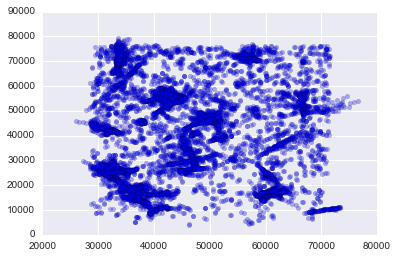

In [326]:
%matplotlib inline
plt.scatter(worked_Data.X, worked_Data.Y ,alpha= 0.3,)
plt.show()

### Try to use DBSCAN with user metric to cluster the showers

In [327]:
def metric_track(parent, son):
    #if abs(parent[2] - son[2]) > 1500:
     #   pass
        #return 10000.
    if parent[2] > son[2]:
        diff = np.append(parent[3:5], 1)
        return np.linalg.norm(np.cross(son[:3] - parent[:3] -  diff, son[:3] - parent[:3]))/np.linalg.norm(diff)
    else:
        diff = np.append(son[3:5], 1)
        return np.linalg.norm(np.cross(parent[:3] - son[:3] -  diff, parent[:3] - son[:3]))/np.linalg.norm(diff)

In [328]:
# look at the distribution of IP between signal tracks.

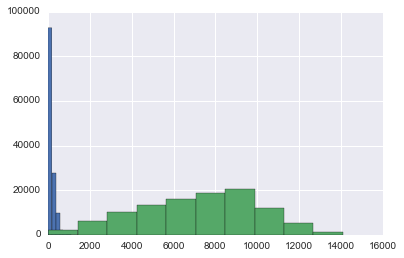

In [329]:
plt.hist(df[df[:, -1] == 1, 2] * dZ);
plt.hist(df[df[:, -1] == 0, 2] * dZ);

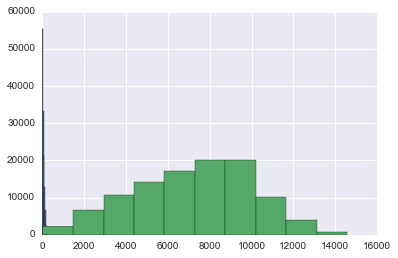

In [330]:
plt.hist(df[df[:, -1] == 1, 3] * dZ);
plt.hist(df[df[:, -1] == 0, 3] * dZ);

In [331]:
from sklearn.cluster import DBSCAN

In [332]:
def plot_multiple_showers(list_of_showers, step = 1, azim = 0, elev = 0):
    colors = np.random.permutation(list(matplotlib.colors.cnames))
    collection = []
    for df, color in zip(list_of_showers, colors):
        d0 = pd.DataFrame([
                    df['Z'][::step],
                    df['X'][::step],
                    df['Y'][::step]],
                    index=['z', 'x', 'y']).T
        numtracks = d0.shape[0]
        dd = pd.DataFrame([
                df['TX'][::step]*dZ,
                df['TY'][::step]*dZ],
                index=['x', 'y']).T
        dd.insert(loc=0, column='z', value=dZ)
        d1 = d0 + dd
        if len(list_of_showers) == 1:
            color = 'red'
        collection.append(Line3DCollection(list(zip(d0.values, d1.values)), colors=color, alpha=0.5, lw=2))


    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    
    for elem in collection:
        ax.add_collection3d(elem)


    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

In [334]:
id_list = list(set(worked_Data.event_id))[-38:]
if -999 not in id_list:
    id_list.append(-999)

In [335]:
test_data = filter(lambda x: x[8] in id_list, list(worked_Data.values))

In [336]:
test_data = pd.DataFrame(np.array(test_data), columns = worked_Data.columns)

In [337]:
len(test_data)

13145

In [338]:
# works good! mean over ip can be used
def metric_track(parent, son):
    if abs(parent[2] - son[2]) > 1500:
        return 10000.
    if parent[2] < son[2]:
        diff = np.append(parent[3:5], 1)
        return np.linalg.norm(np.cross(son[:3] - parent[:3] -  diff, son[:3] - parent[:3]))/np.linalg.norm(diff)
    else:
        diff = np.append(son[3:5], 1)
        return np.linalg.norm(np.cross(parent[:3] - son[:3] -  diff, parent[:3] - son[:3]))/np.linalg.norm(diff)

In [ ]:
%%time
clst = DBSCAN(eps=100, metric=metric_track, n_jobs = -1, min_samples=2) #eps = 100 works well
values = clst.fit_predict(test_data.values[:, :5])

In [ ]:
clustered_showers = []
for i in set(values):
    clustered_showers.append(test_data[values == i])

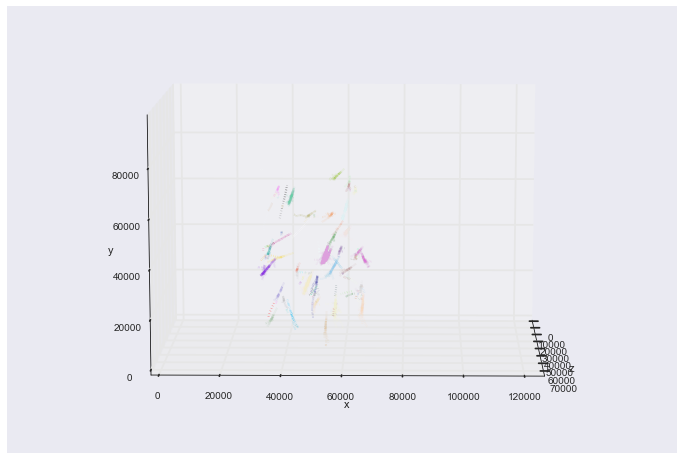

In [92]:
%matplotlib inline
plot_multiple_showers(clustered_showers, azim=1, elev=10)

In [93]:
values += 1
freq = np.bincount(values)
k_th_value = np.sort(freq[1:])[-50] #bad thing here. In the real-world we don't know the number of showers.

In [94]:
cleared_test_data = test_data[np.logical_and(values != 0, freq[values] >= k_th_value)]
cleared_values = values[np.logical_and(values != 0, freq[values] >= k_th_value)]

## Colors of the showers are chosen randomly. Colours could look similar. Maybe you want to try few times.

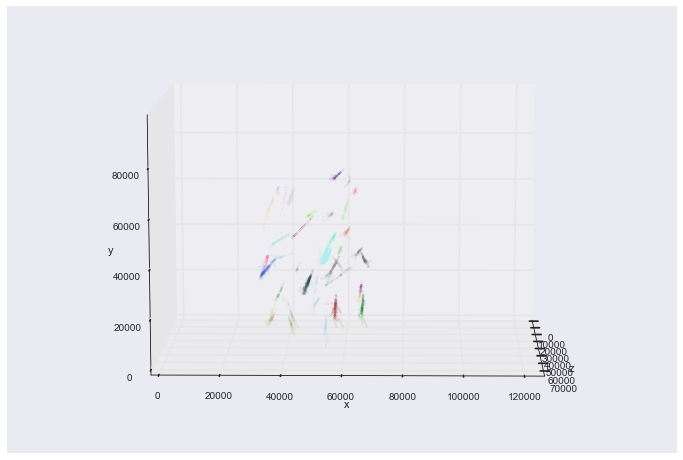

In [95]:
clustered_showers = []
for i in set(cleared_values):
    clustered_showers.append(cleared_data[cleared_values == i])
plot_multiple_showers(clustered_showers, azim=1, elev=10)

In [96]:
len(clustered_showers)

52

# Now we can understand how good we can predict the origins of the shower.
## We will look at the origins of the original and reconstructed showers.

In [97]:
recon_origins = []
for i in range(len(clustered_showers)):
    recon_origins.append(clustered_showers[i].values[np.argmin(clustered_showers[i].Z.values)])

In [98]:
real_origins = []
for i in range(len(recon_origins)):
    shower = cv_data[cv_data.event_id == recon_origins[i][-1]].values
    print np.linalg.norm(shower[np.argmin(shower[:, 2])][:3] - recon_origins[i][:3])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
28472.4808007
0.0
0.0
33862.8190338
8625.22304459
0.0
0.0
0.0
0.0
23295.3047283
29167.9882034
0.0
0.0
0.0
0.0
27411.68912
29788.0405769
0.0
0.0
0.0
12932.787273
53014.125222
29740.3527408
6509.42197066
18165.0359722
0.0
0.0
0.0
20828.1378185
24928.762246
28792.3187914
20750.856392
0.0
43967.7476136


#### 0 indicates that origin was predicted correctly.

## Now, as we already can detect some parts of the shower, we need to find lost tracks using partial inforamtion about shower.

In [99]:
def calculate_shower_loss(list_of_showers, cleared_tracks):
    loss = 0
    for shower in list_of_showers:
        dominating_id = shower.event_id.value_counts().argmax()
        dominating_id_counts = (shower.event_id == dominating_id).sum()
        hits_rate =   float((dominating_id_counts - (shower.shape[0] - dominating_id_counts)))/\
                      float((cleared_tracks.event_id == dominating_id).sum())
            
        loss += hits_rate
    return loss / len(list_of_showers)

In [100]:
calculate_shower_loss(clustered_showers, test_data)

0.5320887785168803

## Now we can analyze shower by shower using for example Hosseini algorithm.